# QRT: Stock Return Prediction

In [162]:
import pandas as pd
import numpy as np
import seaborn as sns
import tqdm as tqdm
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

# Import data

In [163]:
x_train = pd.read_csv('x_train.csv')
y_train = pd.read_csv('y_train.csv')
x_test = pd.read_csv('x_test.csv')

# Data

We have 46 features as follow:
 * **DATE**: index of the date (randomized, no continuity or link between any dates).
 * **STOCK**: index of the stock.
 * **INDUSTRY**: index of the stock industry domain.
 * **INDUSTRY_GROUP**: index of the group industry.
 * **SECTOR**: index of the work sector.
 * **SUB_INDUSTRY**: lower level index of the industry.
 * **RET_1** to **RET_20**: historical residual returns among the last 20 days.
 * **VOLUME_1** to **VOLUME_20**: historical relative volume traded among the last 20 days.
 
Residual returns formula:

![](https://raw.githubusercontent.com/louis-lapassat/qrt/master/85201252_123583422359465_2618136510871896064_n.png)

Relative volume formula:

$$ \bar{V}^t_j = \frac{V^t}{\text{median}(\{V_j^{t-1}, .., V_j^{t-20}\})} $$

$$ \text{relative}\_\text{volume}_j^t = \bar{V}^t_j - \frac{1}{n} \sum_{i=1}^{n}\bar{V}^t_i$$

where $t$ is the time, $j$ is a stock and $n$ is the number of considered stocks.

## Difference between the train and test datasets

In [164]:
x_train.head()

,ID,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,...,RET_16,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20
0,0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,...,0.059459,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937
1,1,0,3,43,15,6,104,0.003984,NaN,-0.090580,...,0.015413,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN
2,2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,...,0.008964,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868
3,3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,...,-0.031769,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458
4,4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,...,-0.038461,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806


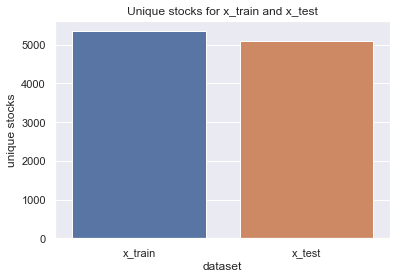

There is 367 new stocks in the test dataset which represents 6.86% of the stocks present in x_train.


In [165]:
### compute the unique number of stocks for each dataset
data = pd.DataFrame(data=[[len(x_train.STOCK.unique()), 'x_train'],
                          [len(x_test.STOCK.unique()), 'x_test']],
                    columns=['unique stocks', 'dataset'])
sns.barplot(x='dataset', y='unique stocks', data=data)
plt.title("Unique stocks for x_train and x_test")
plt.show()

### compute the number of new stocks in the test dataset
unique_stock_train = x_train.STOCK.unique()
is_test_stock_in_train = [stock in unique_stock_train for stock in x_test.STOCK.unique()]
new_stock_test = len(is_test_stock_in_train) - sum(is_test_stock_in_train)
print("There is %d new stocks in the test dataset which represents %.2f%% of the stocks present in x_train."
      %(new_stock_test, (new_stock_test / len(x_train.STOCK.unique())) * 100))

There is not much new stocks in the test dataset but we must verify if they are spread evenly among all classes (industry, industry_group, etc.). In our case we suppose that the classes do not change over time.

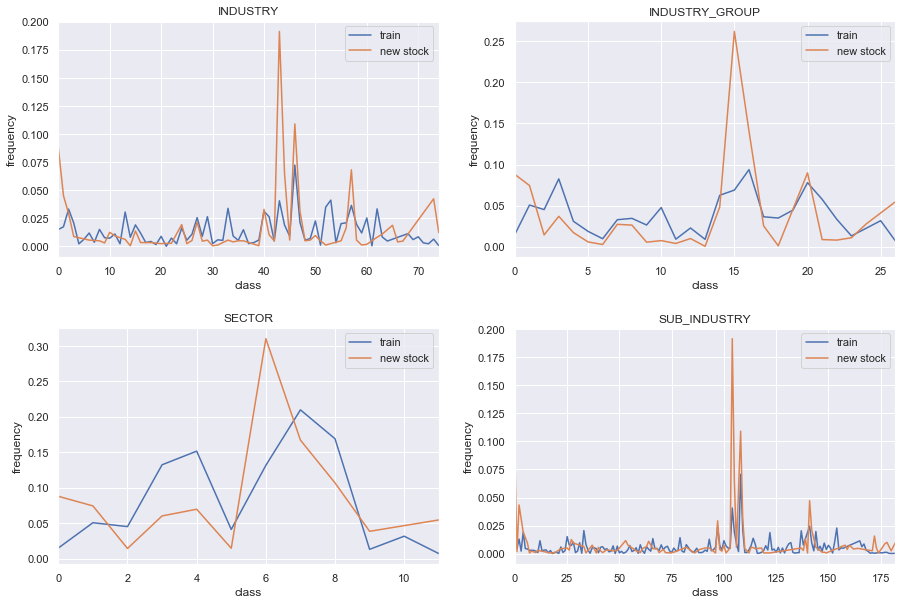

In [166]:
### select the new stocks in test set
mask_new_stocks = [x not in unique_stock_train for x in x_test.STOCK]

plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.3)
for i, col in zip(range(1, 5), ['INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY']):
    plt.subplot(2, 2, i)
    x_train[col].value_counts(normalize=True, sort=False).sort_index().plot(label='train')
    x_test[mask_new_stocks][col].value_counts(normalize=True, sort=False).sort_index().plot(label='new stock')
    plt.xlabel('class')
    plt.ylabel('frequency')
    plt.title(col)
    plt.legend()

plt.show()

It seems like there is some new stocks that are not well represented in the training dataset. For instance, for `INDUSTRY_GROUP` the class $15$ is over represented in the test set (for the new stocks). It would be interesting to look at the error given these specific classes later on.

Finally we will just take a look at the number of NaN in both datasets (this will be further investigate in the next part).

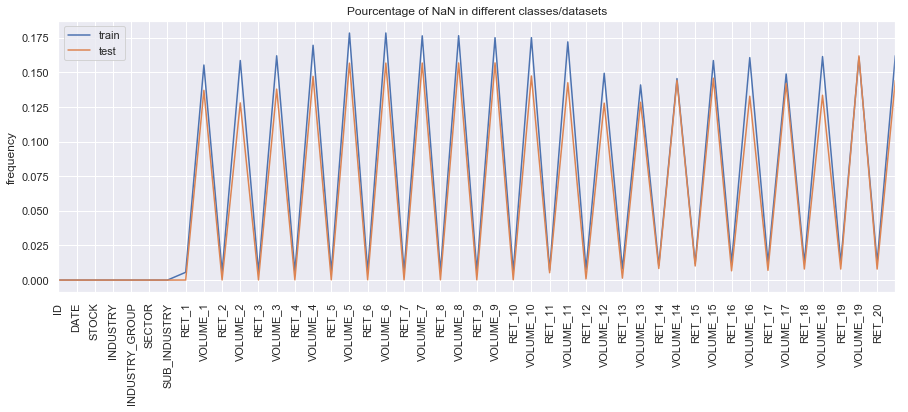

In [167]:
plt.figure(figsize=(15, 5))
(x_train.isna().sum() / len(x_train)).plot(label='train', use_index=False)
(x_test.isna().sum() / len(x_test)).plot(label='test', use_index=False)
plt.xticks(np.arange(46), x_train.columns, rotation=90)
plt.ylabel('frequency')
plt.title("Pourcentage of NaN in different classes/datasets")
plt.legend()
plt.show()

The above figure illustrates that there is almost no difference with the number/repartition of NaN between the two datasets. It also demonstrates that the percentage of NaN in all `VOLUME_` classes is quite high and thus must be further investigate. 

# Feature engineering

## Dealing with NaN

As we saw just before, most of the NaN are localized in `VOLUME_` classes. This could be explained by the fact that the relative volumes are computed using the *median*. And so if one is using the standard median instead of the *nanmedian* (where we ignore nan when computing the median), one will end up with multiple NaNs (for instance, if we have 50 unique dates, and we compute the relative volume over a period of 10 days and if there is an unique NaN at day=20, the relative volume will be a NaN for day=20 to day=30).

Furthermore, NaN present in `RET_` could be explained by the fact that the stock was not open this day/ had a too small number of transactions/ public holiday/ etc.. Then the "first" NaN of `VOLUME_` could be explained the same way and the others with the above explanation.

### 1) First case when all classes `RET_` and `VOLUME_` are NaN

As we can not use the date to reconstruct the dataset, we will try to find some features when there is only NaN for all `RET_` and `VOLUME_`:

In [168]:
start = True
for i in range(1, 21):
    if start:
        start = False
        mask_ret_volume_nan_train = x_train['VOLUME_' + str(i)].isna() & x_train['RET_' + str(i)].isna()
        mask_ret_volume_nan_test = x_test['VOLUME_' + str(i)].isna() & x_test['RET_' + str(i)].isna()
    else:
        mask_ret_volume_nan_train &= x_train['VOLUME_' + str(i)].isna() & x_train['RET_' + str(i)].isna()
        mask_ret_volume_nan_test &= x_test['VOLUME_' + str(i)].isna() & x_test['RET_' + str(i)].isna()
    
index_ret_volume_nan_train = x_train[mask_ret_volume_nan_train].index.values
y_ret_volume_nan_train = y_train.loc[index_ret_volume_nan_train]
index_ret_volume_nan_test = x_test[mask_ret_volume_nan_test].index.values
print("There is %d rows with full NaN, that is %.2f%% of the training set."%(len(y_ret_volume_nan_train),
                                                                             len(y_ret_volume_nan_train) / len(y_train)))
print("In this case, y_train is True in %.2f%% of cases."%((y_ret_volume_nan_train.RET.sum() / len(y_ret_volume_nan_train)) * 100))
print("There is %d rows with full NaN, that is %.2f%% of the testting set."%(len(index_ret_volume_nan_test),
                                                                             len(index_ret_volume_nan_test) / len(x_test)))

There is 2241 rows with full NaN, that is 0.01% of the training set.
In this case, y_train is True in 50.16% of cases.
There is 4 rows with full NaN, that is 0.00% of the testting set.


So there is no obvious patern in *y_train*. These full NaNs could be explained by:

 * the stock has been removed from the stock universe.
 * problems to store the stock's data.
 * the stock was not available to trade during this period.

Finally the absence of pattern in *y_train* might be explained by the fact that we consider the last known price to compute the residual (even if we have NaNs in our dataset) and so even if the stock is no longer tradable, we still compute its residual return (the value in *y_train*). In our case we will test two model one when we drop all these full NaNs and one where we keep them.

TODO: regarder la moyenne du marché en posant beta = 1 et donc alpha (le résidu) vaut - le return du marché

### 2) TODO: other cases

TODO: if NaN use other day instead?

In [169]:
x_train.head()

,ID,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,...,RET_16,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20
0,0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,...,0.059459,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937
1,1,0,3,43,15,6,104,0.003984,NaN,-0.090580,...,0.015413,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN
2,2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,...,0.008964,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868
3,3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,...,-0.031769,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458
4,4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,...,-0.038461,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806


## Feature selection

Here we will only use the first 5 days (suppose that 5 days represent one week). 

TODO: apply log-transformation? + lag analysis + auto-correlation

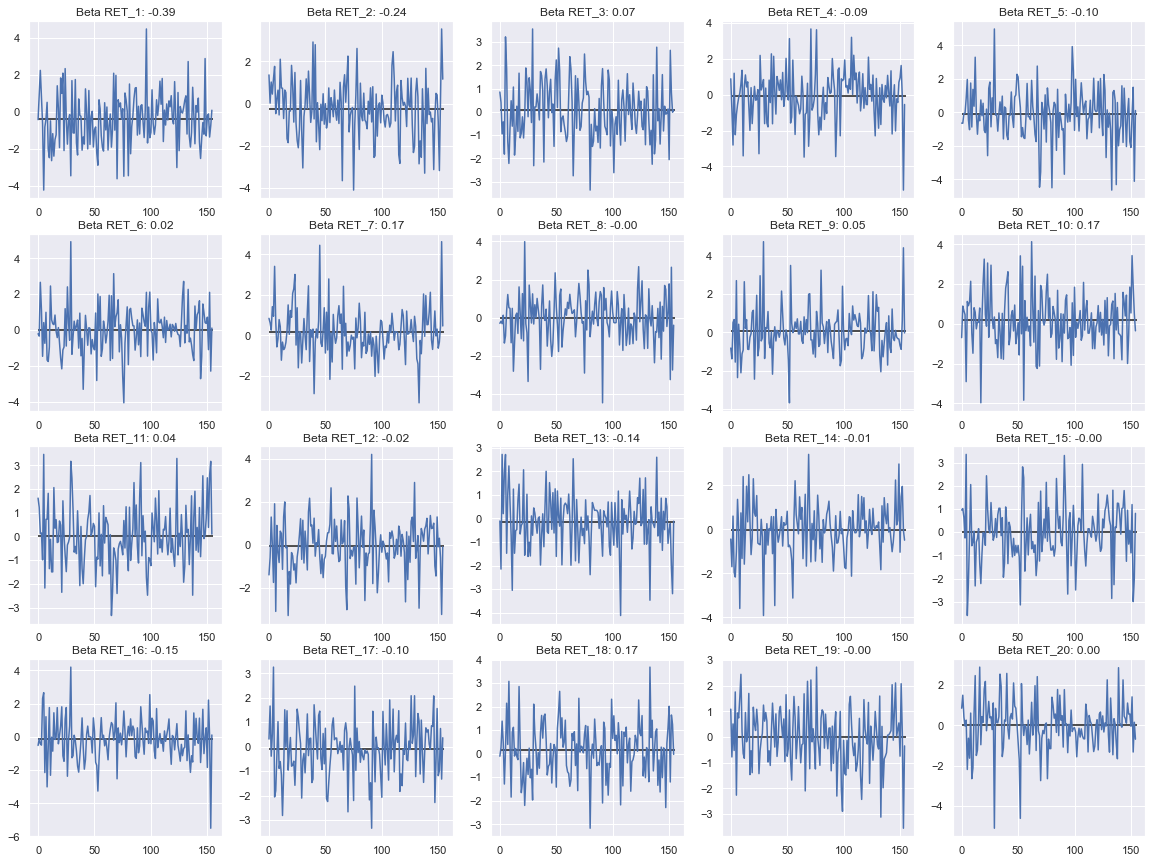

In [170]:
plt.figure(figsize=(20, 15))
mask_na_y_train = ~ y_train['RET'].isna().values
for i, ret in zip(range(1, 21), ['RET_' + str(j) for j in range(1, 21)]):
    ### mask NaN values
    mask_na_x_train = ~ x_train[ret].isna().values
    mask_na = mask_na_x_train & mask_na_y_train

    ### compute betas
    betas = []
    for date in x_train.DATE.unique():
        mask_date = (x_train.DATE == date).values
        mask = mask_date & mask_na

        ### X and Y
        X = x_train[ret][mask].values
        Y = y_train.RET[mask].values * 1

        ### compute beta
        if len(X) > 1:
            betas.append(np.cov(X, Y)[0, 1] / np.var(X))
#         else:
#             print('No values for day:' + str(date))

    ### plot beta
    plt.subplot(4, 5, i)
    plt.title('Beta ' + ret + ": %.2f"%(np.mean(betas)))
    plt.plot(betas)
    plt.hlines(np.mean(betas), 0, len(betas))
plt.show()

# Technical features
## Average of the residual returns (per week)
Refers to the moving average of the turnover over a certain period

In [171]:
dic = {}
for week in range(2):
    features = []
    for day in range(1, 6):
        features.append('RET_' + str(week * 5 + day))
    dic['AVG_RET_' + str(week + 1)] = x_train[features].mean(axis=1)
technical_features = pd.DataFrame(dic)
pd.DataFrame(dic).head()

,AVG_RET_1,AVG_RET_2
0,-0.003694,0.059023
1,-0.026274,0.038943
2,-0.006658,0.010191
3,0.003658,-0.011622
4,0.002059,-0.002470


## Moving average of residual returns
Over 1, 2, 3, 4 weeks.

In [172]:
#features = []
#dic = {}
#for week in range(2):
#    for day in range(1, 6):
#        features.append('RET_' + str(week * 5 + day))
#    dic['MVG_RET_' + str(week + 1)] = x_train[features].mean(axis=1)
#technical_features = pd.concat((technical_features, pd.DataFrame(dic)), axis=1)
#pd.DataFrame(dic).head()

## Refers to a rate of acceleration of a stock’s volume and can be used to help identify trend lines of volume

https://reader.elsevier.com/reader/sd/pii/S2405844019359705?token=59DFDC80F40A2CA16BBA8F76DBDD22B838D9E5036C171BD12ED5F6291A663A49BB35626EC2243690CE7FE855468D1EB7

In [173]:
dic = {}
features = []
for week in range(4):
    for day in range(1, 6):
        features.append('VOLUME_' + str(week * 5 + day))
    dic['VOL_' + str(week + 1)] = x_train[features].mean(axis=1)
res = {}
res['VOL_1/VOL_2'] = dic['VOL_1'] / dic['VOL_2']
res['VOL_1/VOL_3'] = dic['VOL_1'] / dic['VOL_3']
res['VOL_1/VOL_4'] = dic['VOL_1'] / dic['VOL_4']
#res['VOL_2/VOL_3'] = dic['VOL_2'] / dic['VOL_3'] 
#res['VOL_2/VOL_4'] = dic['VOL_2'] / dic['VOL_4'] 
#res['VOL_3/VOL_4'] = dic['VOL_3'] / dic['VOL_4']
technical_features = pd.concat((technical_features, pd.DataFrame(res)), axis=1)
pd.DataFrame(res).head()

,VOL_1/VOL_2,VOL_1/VOL_3,VOL_1/VOL_4
0,-0.154314,-0.331097,-0.426286
1,NaN,NaN,NaN
2,0.482402,0.426954,0.358949
3,1.399066,1.034698,1.106327
4,1.266714,-1.510818,-1.810634


## Refers to the volatility over the past m trading days as calculated by the standard deviation of daily returns

In [174]:
dic = {}
features = []
for week in range(4):
    for day in range(1, 6):
        features.append('RET_' + str(week * 5 + day))
    dic['STD_RET_' + str(week + 1)] = x_train[features].std(axis=1)
technical_features = pd.concat((technical_features, pd.DataFrame(dic)), axis=1)
pd.DataFrame(dic).head()

,STD_RET_1,STD_RET_2,STD_RET_3,STD_RET_4
0,0.016027,0.071108,0.061764,0.054646
1,0.042498,0.065736,0.055483,0.048808
2,0.031757,0.031049,0.026459,0.023417
3,0.018668,0.020922,0.018406,0.020831
4,0.026294,0.022812,0.034238,0.032045


## STD of volume
Refers to the standard deviation of trading volume time series over the pastmtrading days

In [175]:
dic = {}
features = []
for week in range(4):
    for day in range(1, 6):
        features.append('VOLUME_' + str(week * 5 + day))
    dic['STD_VOL_' + str(week + 1)] = x_train[features].std(axis=1)
technical_features = pd.concat((technical_features, pd.DataFrame(dic)), axis=1)
pd.DataFrame(dic).head()

,STD_VOL_1,STD_VOL_2,STD_VOL_3,STD_VOL_4
0,0.485623,2.816734,2.497299,2.163249
1,NaN,NaN,NaN,NaN
2,0.166250,0.342035,0.283777,0.264779
3,0.348658,0.459691,0.579454,0.518702
4,0.194741,0.390729,5.062285,4.355388


### Final technical features


In [176]:
technical_features.head()

,AVG_RET_1,AVG_RET_2,VOL_1/VOL_2,VOL_1/VOL_3,VOL_1/VOL_4,STD_RET_1,STD_RET_2,STD_RET_3,STD_RET_4,STD_VOL_1,STD_VOL_2,STD_VOL_3,STD_VOL_4
0,-0.003694,0.059023,-0.154314,-0.331097,-0.426286,0.016027,0.071108,0.061764,0.054646,0.485623,2.816734,2.497299,2.163249
1,-0.026274,0.038943,NaN,NaN,NaN,0.042498,0.065736,0.055483,0.048808,NaN,NaN,NaN,NaN
2,-0.006658,0.010191,0.482402,0.426954,0.358949,0.031757,0.031049,0.026459,0.023417,0.166250,0.342035,0.283777,0.264779
3,0.003658,-0.011622,1.399066,1.034698,1.106327,0.018668,0.020922,0.018406,0.020831,0.348658,0.459691,0.579454,0.518702
4,0.002059,-0.002470,1.266714,-1.510818,-1.810634,0.026294,0.022812,0.034238,0.032045,0.194741,0.390729,5.062285,4.355388


# Using sectors

Until now we didn't used the sectors, date.

In [177]:
x_train.head()

,ID,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,...,RET_16,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20
0,0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,...,0.059459,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937
1,1,0,3,43,15,6,104,0.003984,NaN,-0.090580,...,0.015413,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN
2,2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,...,0.008964,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868
3,3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,...,-0.031769,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458
4,4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,...,-0.038461,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806


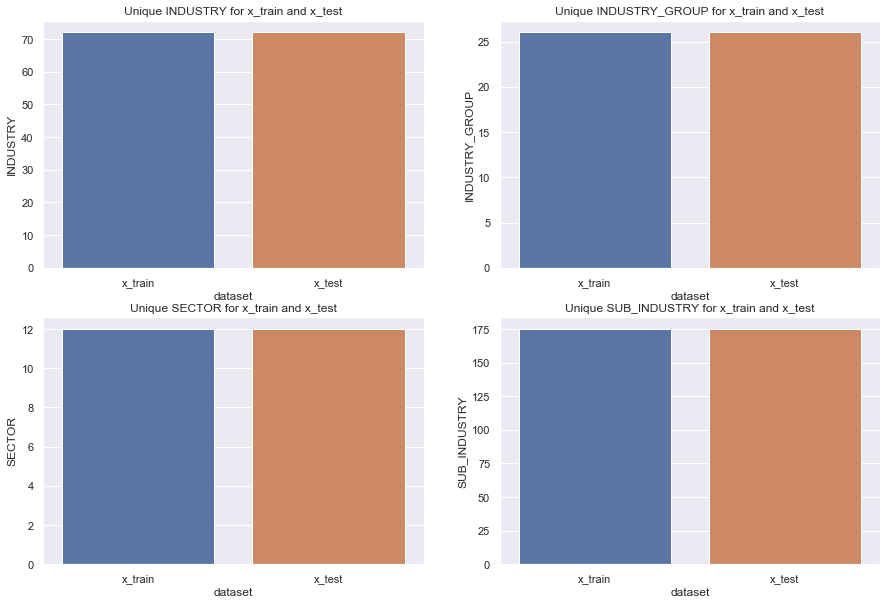

In [178]:
### compute the unique number of stocks for each dataset
data = pd.DataFrame(data=[[len(x_train.INDUSTRY.unique()), len(x_train.INDUSTRY_GROUP.unique()),
                           len(x_train.SECTOR.unique()), len(x_train.SUB_INDUSTRY.unique()), 'x_train'],
                          [len(x_train.INDUSTRY.unique()), len(x_train.INDUSTRY_GROUP.unique()),
                           len(x_train.SECTOR.unique()), len(x_train.SUB_INDUSTRY.unique()), 'x_test'],],
                    columns=['INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY', 'dataset'])
plt.figure(figsize=(15, 10))
for i, title in zip(range(1, 5), ['INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY']):
    plt.subplot(2, 2, i)
    sns.barplot(x='dataset', y=title, data=data)
    plt.title("Unique " + title + " for x_train and x_test")
plt.show()

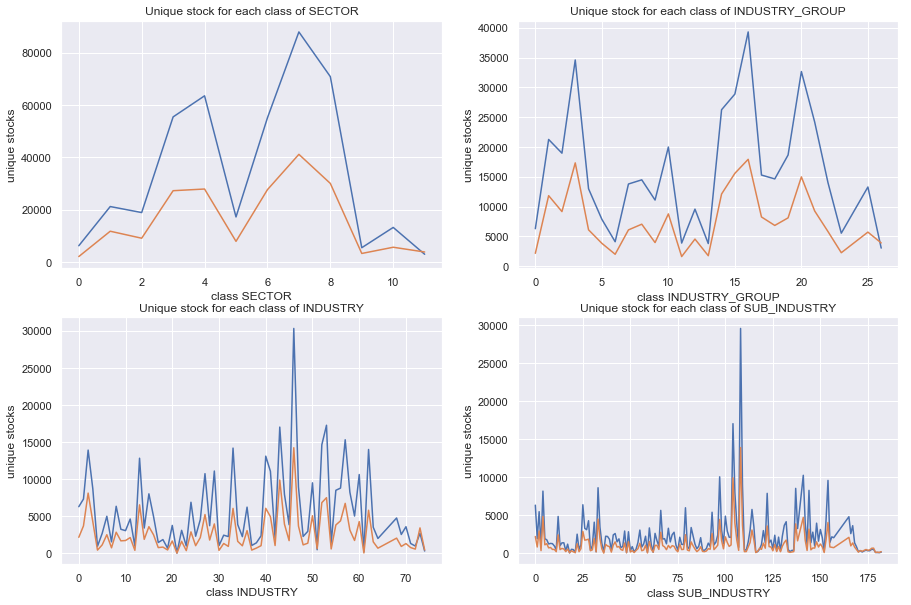

In [179]:
plt.figure(figsize=(15, 10))
for i, title in zip(range(1, 5), ['SECTOR', 'INDUSTRY_GROUP', 'INDUSTRY', 'SUB_INDUSTRY']):
    dic = {}
    dic_test = {}
    plt.subplot(2, 2, i)
    for sector in x_train[title].unique():
        dic[sector] = len(x_train[x_train[title] == sector]['ID'].unique())
        dic_test[sector] = len(x_test[x_test[title] == sector]['ID'].unique())
    x, y = zip(*sorted(dic.items()))
    plt.plot(x, y)
    x, y = zip(*sorted(dic_test.items()))
    plt.plot(x, y)
    plt.title('Unique stock for each class of ' + title)
    plt.xlabel('class ' + title)
    plt.ylabel('unique stocks')
plt.show()

In our case we will only choose `SECTOR` and `INDUSTRY_GROUP` (reduce the size of the families).

In [180]:
dic = {}
features = []
for week in range(4):
    for day in range(1, 6):
        features.append('VOLUME_' + str(week * 5 + day))
    dic['VOL_' + str(week + 1)] = x_train[features].mean(axis=1).abs()
pd.DataFrame(dic).head()

,VOL_1,VOL_2,VOL_3,VOL_4
0,0.194968,1.263455,0.588855,0.457365
1,NaN,NaN,NaN,NaN
2,0.075251,0.155992,0.176250,0.209642
3,0.596365,0.426259,0.576366,0.539049
4,1.097822,0.866669,0.726641,0.606319


In [181]:
df = pd.concat((x_train, pd.DataFrame(dic)), axis=1)
rt = pd.DataFrame()
rt['PER_VOL_1'] = df['VOL_1'] / df.groupby(['SECTOR', 'DATE'])['VOL_1'].transform('sum')
rt['PER_VOL_2'] = df['VOL_2'] / df.groupby(['SECTOR', 'DATE'])['VOL_2'].transform('sum')
rt['PER_VOL_3'] = df['VOL_3'] / df.groupby(['SECTOR', 'DATE'])['VOL_3'].transform('sum')
rt['PER_VOL_4'] = df['VOL_4'] / df.groupby(['SECTOR', 'DATE'])['VOL_4'].transform('sum')

In [182]:
technical_features = pd.concat((rt, technical_features), axis=1)

In [183]:
technical_features['COND_AVG_RET_1'] = x_train.groupby(['SECTOR', 'DATE'])['RET_1'].transform('mean')
technical_features['COND_AVG_RET_2'] = x_train.groupby(['SECTOR', 'DATE'])['RET_2'].transform('mean')
technical_features['COND_AVG_VOL_1'] = x_train.groupby(['SECTOR', 'DATE'])['VOLUME_1'].transform('mean')

In [184]:
technical_features.head()

,PER_VOL_1,PER_VOL_2,PER_VOL_3,PER_VOL_4,AVG_RET_1,AVG_RET_2,VOL_1/VOL_2,VOL_1/VOL_3,VOL_1/VOL_4,STD_RET_1,STD_RET_2,STD_RET_3,STD_RET_4,STD_VOL_1,STD_VOL_2,STD_VOL_3,STD_VOL_4,COND_AVG_RET_1,COND_AVG_RET_2,COND_AVG_VOL_1
0,0.001409,0.010531,0.005171,0.004717,-0.003694,0.059023,-0.154314,-0.331097,-0.426286,0.016027,0.071108,0.061764,0.054646,0.485623,2.816734,2.497299,2.163249,0.009178,-0.017313,0.006771
1,NaN,NaN,NaN,NaN,-0.026274,0.038943,NaN,NaN,NaN,0.042498,0.065736,0.055483,0.048808,NaN,NaN,NaN,NaN,0.006477,-0.023300,0.009725
2,0.000307,0.000740,0.000963,0.001375,-0.006658,0.010191,0.482402,0.426954,0.358949,0.031757,0.031049,0.026459,0.023417,0.166250,0.342035,0.283777,0.264779,0.013449,-0.045074,0.124151
3,0.019599,0.013959,0.019010,0.020864,0.003658,-0.011622,1.399066,1.034698,1.106327,0.018668,0.020922,0.018406,0.020831,0.348658,0.459691,0.579454,0.518702,0.017253,0.001304,-0.121974
4,0.024679,0.017894,0.015219,0.016041,0.002059,-0.002470,1.266714,-1.510818,-1.810634,0.026294,0.022812,0.034238,0.032045,0.194741,0.390729,5.062285,4.355388,0.006241,-0.014918,-0.190113


In [185]:
#technical_features = technical_features.drop('STD_VOL_1', axis=1)

In [186]:
#technical_features = technical_features.drop('EXT_VOL_1', axis=1)

In [187]:
#technical_features = pd.concat((x_train[['RET_1']], technical_features), axis=1)

In [188]:
x_train.columns

Index(['ID', 'DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR',
       'SUB_INDUSTRY', 'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3',
       'VOLUME_3', 'RET_4', 'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6',
       'VOLUME_6', 'RET_7', 'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9',
       'VOLUME_9', 'RET_10', 'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12',
       'VOLUME_12', 'RET_13', 'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15',
       'VOLUME_15', 'RET_16', 'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18',
       'VOLUME_18', 'RET_19', 'VOLUME_19', 'RET_20', 'VOLUME_20'],
      dtype='object')

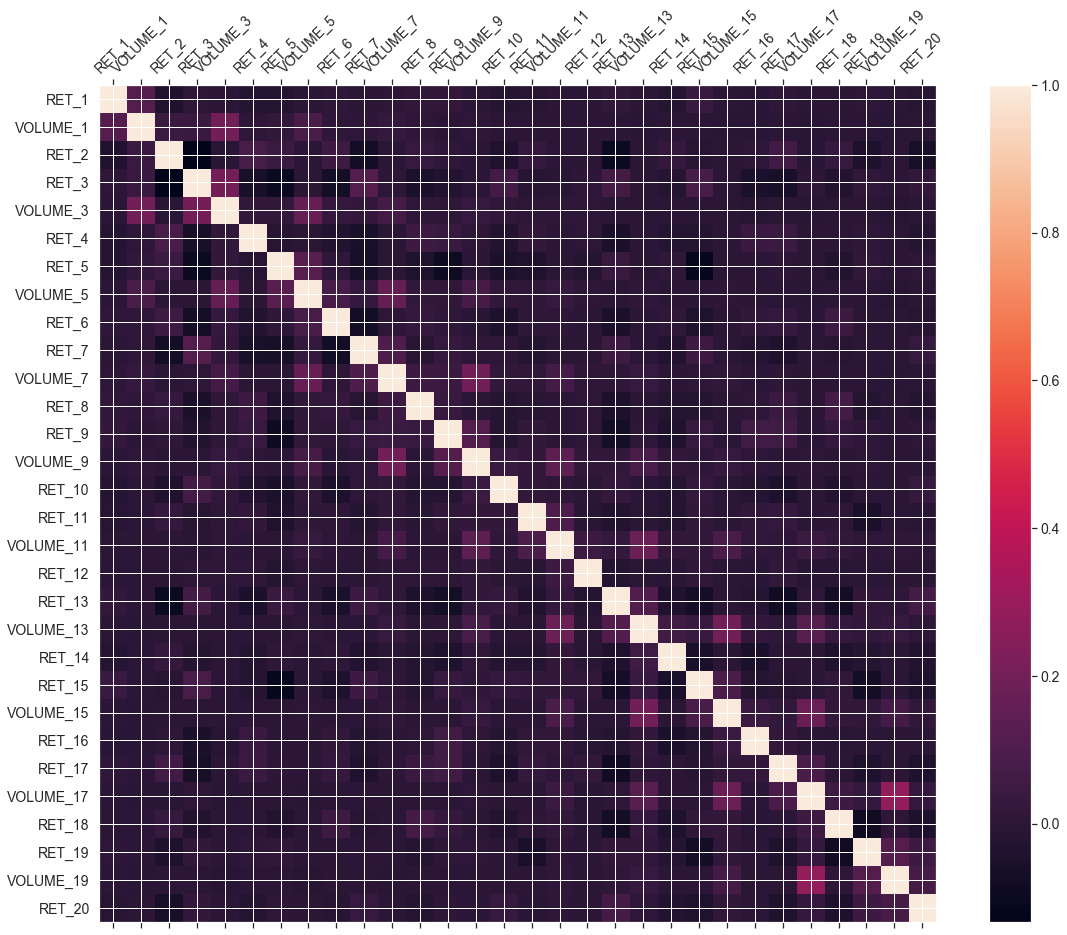

In [189]:
import matplotlib.pyplot as plt
drop_feat = ['ID', 'DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR','SUB_INDUSTRY']
for col in ['VOLUME_' + str(i) for i in range(2, 21, 2)]:
    drop_feat += [col]

f = plt.figure(figsize=(19, 15))
plt.matshow(x_train.drop(drop_feat, axis=1).corr(), fignum=f.number)
plt.xticks(range(x_train.drop(drop_feat, axis=1).shape[1]), x_train.drop(drop_feat, axis=1).columns, fontsize=14, rotation=45)
plt.yticks(range(x_train.drop(drop_feat, axis=1).shape[1]), x_train.drop(drop_feat, axis=1).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [190]:
#x_train.drop(drop_feat, axis=1).corr() > 0.8

### Faire un indicateur qui indique si on est dans les extremes (genre les 2-1% dans les gaussiennes)

In [192]:
technical_features['EXT_VOL_1'] = 0
for date in tqdm.tqdm_notebook(x_train.DATE.unique()):
    for sector in x_train.SECTOR.unique():
        mask = (x_train.DATE == date) & (x_train.SECTOR == sector)
        if mask.sum() > 0:
            q_975 = x_train[mask]['VOLUME_1'].quantile(0.975)
            q_025 = x_train[mask]['VOLUME_1'].quantile(0.025)
            technical_features.loc[mask, 'EXT_VOL_1'] = (x_train[mask]['VOLUME_1'] >= q_975) * 1
            technical_features.loc[mask, 'EXT_VOL_1'] = (x_train[mask]['VOLUME_1'] <= q_025) * (- 1)

In [193]:
technical_features['SIG_RET'] = (x_train[['RET_1', 'RET_2']] > 0).sum(axis=1)
technical_features['SIG_VOL'] = (x_train[['VOLUME_1', 'VOLUME_2']] > 0).sum(axis=1)

In [194]:
## real return sqrt(prod_1_n 1 + r_i/100, n)
X = np.ones(len(x_train))
for col in ['RET_' + str(i) for i in range(1, 3)]:
    X *= 1 + x_train[col] / 100 
technical_features['REAL_RET'] = X ** (1 / 2)

In [195]:
## Non-systematic risk 
mean_1 = x_train.groupby(['SECTOR', 'DATE'])['RET_1'].transform('mean')
mean_2 = x_train.groupby(['SECTOR', 'DATE'])['RET_2'].transform('mean')
technical_features['NON_SYS_RISK'] = np.sqrt((x_train['RET_1'] - mean_1) ** 2 + (x_train['RET_2'] - mean_2) ** 2)

In [196]:
technical_features.columns

Index(['PER_VOL_1', 'PER_VOL_2', 'PER_VOL_3', 'PER_VOL_4', 'AVG_RET_1',
       'AVG_RET_2', 'VOL_1/VOL_2', 'VOL_1/VOL_3', 'VOL_1/VOL_4', 'STD_RET_1',
       'STD_RET_2', 'STD_RET_3', 'STD_RET_4', 'STD_VOL_1', 'STD_VOL_2',
       'STD_VOL_3', 'STD_VOL_4', 'COND_AVG_RET_1', 'COND_AVG_RET_2',
       'COND_AVG_VOL_1', 'EXT_VOL_1', 'SIG_RET', 'SIG_VOL', 'REAL_RET',
       'NON_SYS_RISK'],
      dtype='object')

# Feature selection

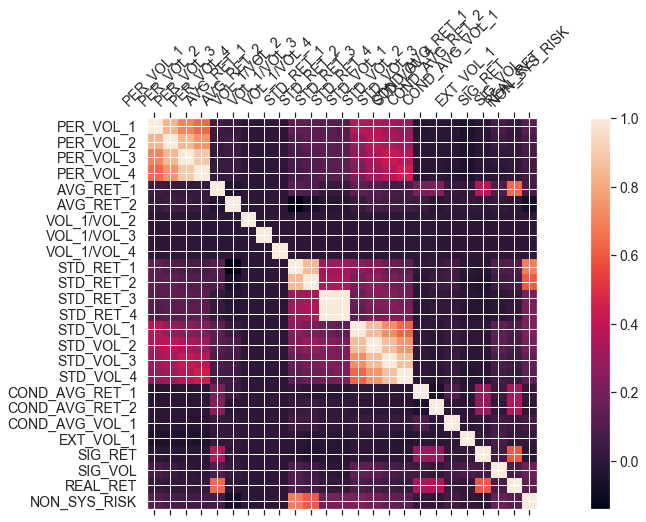

In [200]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(19, 7))
plt.matshow(technical_features.corr(), fignum=f.number)
plt.xticks(range(technical_features.shape[1]), technical_features.columns, fontsize=14, rotation=45)
plt.yticks(range(technical_features.shape[1]), technical_features.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [203]:
list_corr = (technical_features.corr() > 0.95).stack().index.tolist()
to_del = []
for x, y in list_corr:
    if x != y:
        to_del += [x, y]

In [204]:
to_del

['PER_VOL_1',
 'PER_VOL_2',
 'PER_VOL_1',
 'PER_VOL_3',
 'PER_VOL_1',
 'PER_VOL_4',
 'PER_VOL_1',
 'AVG_RET_1',
 'PER_VOL_1',
 'AVG_RET_2',
 'PER_VOL_1',
 'VOL_1/VOL_2',
 'PER_VOL_1',
 'VOL_1/VOL_3',
 'PER_VOL_1',
 'VOL_1/VOL_4',
 'PER_VOL_1',
 'STD_RET_1',
 'PER_VOL_1',
 'STD_RET_2',
 'PER_VOL_1',
 'STD_RET_3',
 'PER_VOL_1',
 'STD_RET_4',
 'PER_VOL_1',
 'STD_VOL_1',
 'PER_VOL_1',
 'STD_VOL_2',
 'PER_VOL_1',
 'STD_VOL_3',
 'PER_VOL_1',
 'STD_VOL_4',
 'PER_VOL_1',
 'COND_AVG_RET_1',
 'PER_VOL_1',
 'COND_AVG_RET_2',
 'PER_VOL_1',
 'COND_AVG_VOL_1',
 'PER_VOL_1',
 'EXT_VOL_1',
 'PER_VOL_1',
 'SIG_RET',
 'PER_VOL_1',
 'SIG_VOL',
 'PER_VOL_1',
 'REAL_RET',
 'PER_VOL_1',
 'NON_SYS_RISK',
 'PER_VOL_2',
 'PER_VOL_1',
 'PER_VOL_2',
 'PER_VOL_3',
 'PER_VOL_2',
 'PER_VOL_4',
 'PER_VOL_2',
 'AVG_RET_1',
 'PER_VOL_2',
 'AVG_RET_2',
 'PER_VOL_2',
 'VOL_1/VOL_2',
 'PER_VOL_2',
 'VOL_1/VOL_3',
 'PER_VOL_2',
 'VOL_1/VOL_4',
 'PER_VOL_2',
 'STD_RET_1',
 'PER_VOL_2',
 'STD_RET_2',
 'PER_VOL_2',
 'STD_RET

In [120]:
from sklearn.feature_selection import RFE

In [122]:
estimator = RandomForestClassifier(n_estimators=60, max_depth=2 ** 3, random_state=0, n_jobs=-1)
selector = RFE(estimator, 5, step=1)
selector = selector.fit(technical_features.fillna(0), y_train['RET'])

In [123]:
selector.support_

array([False,  True, False, False,  True,  True,  True,  True, False,
       False])

In [124]:
selector.ranking_

array([2, 1, 4, 3, 1, 1, 1, 1, 5, 6])

# Model

Hybrid models have been successful in financial research applications (conventional + neural networks + SVR + random forest + AR + LSTM).

In [26]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [197]:
X_train = technical_features
Y_train = y_train['RET']

## only select not na
X_train = technical_features.dropna()
idx = X_train.index
Y_train = y_train.loc[idx]['RET']

# A quiet large number of trees with low depth to prevent overfits
rf_params = {
    'n_estimators': 60,
    'max_depth': 2 ** 3,
    'random_state': 0,
    'n_jobs': -1
}

train_dates = x_train['DATE'].unique()
test_dates = x_test['DATE'].unique()

n_splits = 4
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = x_train['DATE'].isin(local_train_dates)
    local_test_ids = x_train['DATE'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids]
    y_local_train = Y_train.loc[local_train_ids]
    X_local_test = X_train.loc[local_test_ids]
    y_local_test = Y_train.loc[local_test_ids]

    X_local_train = X_local_train.fillna(0)
    X_local_test = X_local_test.fillna(0)

    model = RandomForestClassifier(**rf_params)
    model.fit(X_local_train, y_local_train)

    y_local_pred = model.predict_proba(X_local_test)[:, 1]
    
    sub = X_train.loc[local_test_ids].copy()
    sub['DATE'] = x_train.loc[sub.index]['DATE']
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.mean()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores) * 100
std = np.std(scores) * 100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Fold 1 - Accuracy: 52.63%
Fold 2 - Accuracy: 49.66%
Fold 3 - Accuracy: 50.68%
Fold 4 - Accuracy: 50.89%
Accuracy: 50.96% [49.90 ; 52.03] (+- 1.07)


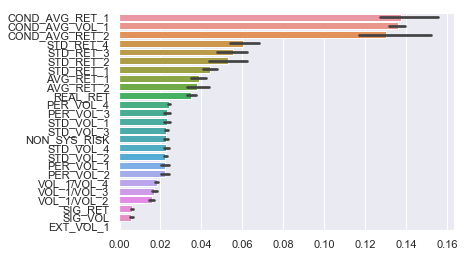

In [198]:
feature_importances = pd.DataFrame([model.feature_importances_ for model in models],
                                   columns=technical_features.columns)

sns.barplot(data=feature_importances, orient='h',
            order=feature_importances.mean().sort_values(ascending=False).index)
plt.show()

<IPython.core.display.Javascript object>


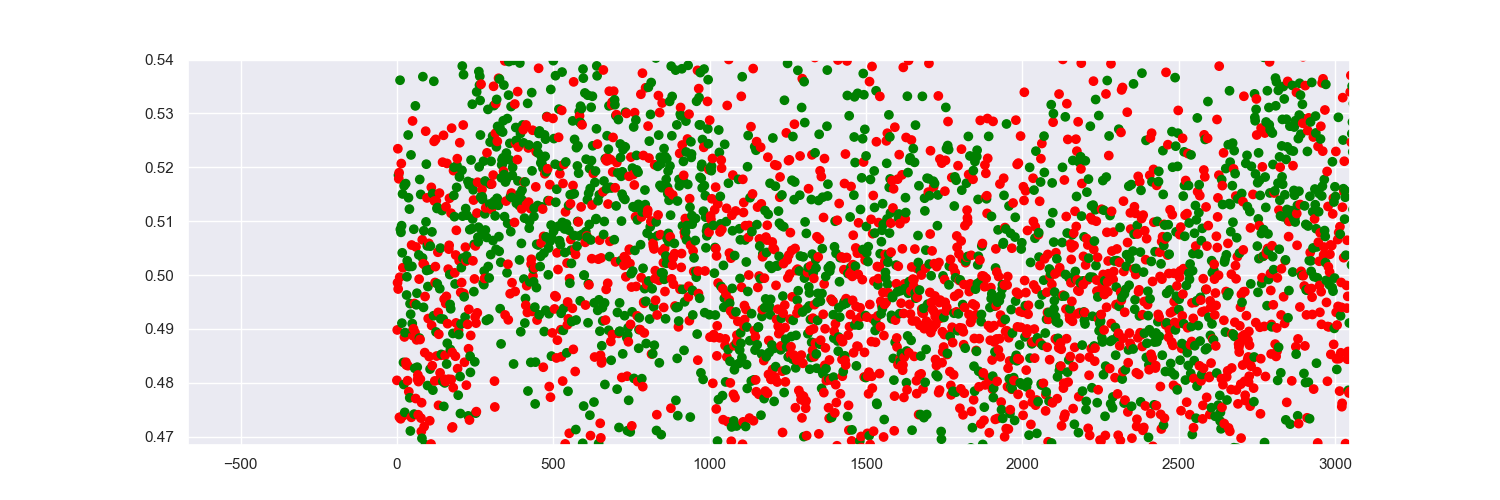

In [85]:
%matplotlib notebook
plt.figure(figsize=(15, 5))
plt.scatter(range(len(sub)), sub['pred'].values, color=['green' if y else 'red' for y in y_local_test])
plt.show()